# Airbnb Project

Airbnb is a global platform helping travelers to find home rentals and experiences all across the globe. Airbnb encourages hosts to post their listings for rental business and guests to book their stay. 

Here, for the project, we will explore the Airbnb dataset to understand what features drive revenue in the Airbnb rental business. Ultimately, our goal is to find what makes a listing successful.

# 1. Airbnb Data
Data Source: http://insideairbnb.com/get-the-data.html

Airbnb datasets:
- Listings.csv
- Reviews.csv

The above datasets provide detailed Listings data along with Reviews for each listing. Some of the features that these datasets contain are:

- bedrooms: number of bedrooms in a listing
- bathrooms: number of bathrooms in a listing
- beds: number of beds in a listing
- property_type: the type of property (House, Apartment,..., Others)
- room_type: the type of room (Entire Apartment or house, Shared room)
- amenities: amenities for the listing (Internet, TV, etc.)
- price: price per night
- host_is_superhost: is the host super host or not
- review_rating_score: rating from guests
- number of reviews: number of reviews for a listing
- reviews: the text of the reviews of a listing (separate table)

In this data exploration exercise we will precise the analysis on the Airbnb listings to Los Angeles, CA, United States.

We will define <b><i>'revenue'</i></b> as the price of a listing multiplied by the number of days that the listing is booked in the next 30 days, and <b><i>'is_sucessful'</i></b> as a dummy variable that will take the value of 1 if revenue's listing is above the average revenue with respect to the listings with similar room type and number of bedrooms, and 0 otherwise. The latter variable, will be our target variable when we try to predict what drives revenue.
    
We will also process 600,000 reviews to perform sentiment analysis on the texts. These sentiment scores of the anlysis will be an additional feature to the dataset.

In [4]:
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
df_listings = pd.read_csv("listings.csv")
df_reviews = pd.read_csv("reviews.csv")

# 2. Exploring and Cleaning The Data

In this notebook we will explore the Airbnb dataset in order to prepare the data to get insights and to train a classifier.

The variables that we will clean and fix are the following:

- <b>property_type:</b> This attribute has a lot of different values, so we will keep just 10 categories, transforming those with the least frequency into "Other".
- <b>price:</b> This attribute is in text format, so we will transform it to numerical
- <b>dummy variables:</b> The dummy variables in the dataset have value "t" or "f", so we will transform them to dummy variables 1 and 0 respectively.
- <b>NAs:</b> Some attributes have NA values so we will fill those values
- <b>amenities:</b> Each list has a set of values with its amenities. Based on the unique list of all the amenities possible, we will create a dummy variable for each one to capture the amenities that a particular listing has.


We will create the following features:

- <b>revenue:</b> price * number of days that the listing is booked in the next 30 days
- <b>sentiment_nltk:</b> Based on the text from the reviews for each listing, we will perform sentiment analysis to get the average sentiment score for each listing. This value is a number between -1 and 1.
- <b>is_successful_c:</b> This dummy variable will take the value of 1 if revenue's listing is above the average revenue with respect to  the listings with similar room type and number of bedrooms, and 0 otherwise.
- <b>clean_perc:</b> This represents what percentage of the price is charged as cleaning fee.
- <b>request_deposit:</b> This dummy variable will take the value of 1 if the listing requires a credit deposit and 0 otherwise

## 2.1 Overview

In [5]:
##Overview of the data
len(df_listings)
df_listings.head()
df_listings.columns

df_listings.info()

31253

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,16228948,https://www.airbnb.com/rooms/16228948,20170502172350,2017-05-03,Robert Ranch in Los Angeles for filming/wedding,Stunning Ranch Estate situated on 20 acres and...,NaN,Stunning Ranch Estate situated on 20 acres and...,none,NaN,...,NaN,f,NaN,NaN,t,strict,f,f,1,NaN
1,8909380,https://www.airbnb.com/rooms/8909380,20170502172350,2017-05-03,Nice quiet private ranch house,NaN,Very private and quite . Hiking horse riding a...,Very private and quite . Hiking horse riding a...,none,I'm in the country what's not to love about that,...,9.0,f,NaN,NaN,f,flexible,f,f,1,1.91
2,14078522,https://www.airbnb.com/rooms/14078522,20170502172350,2017-05-03,Room w/private bath on Small Ranch,My place is close to Six Flags Magic Mountain ...,Room with queen bed and private bath,My place is close to Six Flags Magic Mountain ...,none,Horse area. Trails for hiking and riding. Quie...,...,10.0,f,NaN,NaN,f,flexible,f,f,1,1.72
3,13006928,https://www.airbnb.com/rooms/13006928,20170502172350,2017-05-03,Miller Ranch Bunkhouse,"Our place is close to great views, equestrian ...",Please know that we live on a dirt road but it...,"Our place is close to great views, equestrian ...",none,NaN,...,10.0,f,NaN,NaN,t,flexible,f,f,1,2.12
4,7898757,https://www.airbnb.com/rooms/7898757,20170502172350,2017-05-03,Studio with full bathroom,Fully furnished studio only a 10 min drive fro...,NaN,Fully furnished studio only a 10 min drive fro...,none,NaN,...,10.0,f,NaN,"City of Los Angeles, CA",f,flexible,f,f,1,0.18


Index([u'id', u'listing_url', u'scrape_id', u'last_scraped', u'name',
       u'summary', u'space', u'description', u'experiences_offered',
       u'neighborhood_overview', u'notes', u'transit', u'access',
       u'interaction', u'house_rules', u'thumbnail_url', u'medium_url',
       u'picture_url', u'xl_picture_url', u'host_id', u'host_url',
       u'host_name', u'host_since', u'host_location', u'host_about',
       u'host_response_time', u'host_response_rate', u'host_acceptance_rate',
       u'host_is_superhost', u'host_thumbnail_url', u'host_picture_url',
       u'host_neighbourhood', u'host_listings_count',
       u'host_total_listings_count', u'host_verifications',
       u'host_has_profile_pic', u'host_identity_verified', u'street',
       u'neighbourhood', u'neighbourhood_cleansed',
       u'neighbourhood_group_cleansed', u'city', u'state', u'zipcode',
       u'market', u'smart_location', u'country_code', u'country', u'latitude',
       u'longitude', u'is_location_exact', u'prope

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31253 entries, 0 to 31252
Data columns (total 95 columns):
id                                  31253 non-null int64
listing_url                         31253 non-null object
scrape_id                           31253 non-null int64
last_scraped                        31253 non-null object
name                                31246 non-null object
summary                             30417 non-null object
space                               21866 non-null object
description                         31238 non-null object
experiences_offered                 31253 non-null object
neighborhood_overview               18575 non-null object
notes                               13815 non-null object
transit                             18164 non-null object
access                              19074 non-null object
interaction                         18262 non-null object
house_rules                         22047 non-null object
thumbnail_url          

In [6]:
##Check some features

df_listings[['id','city','state','market','property_type','room_type',
             'accommodates','bathrooms','bedrooms','beds','bed_type',
             'amenities','square_feet','price','availability_30',
             'availability_60','availability_90','availability_365',
             'number_of_reviews','reviews_per_month','review_scores_rating','last_scraped']]

,id,city,state,market,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,square_feet,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,reviews_per_month,review_scores_rating,last_scraped
0,16228948,Acton,CA,Other (Domestic),House,Entire home/apt,10,7.0,5.0,5.0,...,NaN,"$3,000.00",27,53,82,352,0,NaN,NaN,2017-05-03
1,8909380,Palmdale,CA,Other (Domestic),House,Private room,2,1.0,1.0,1.0,...,NaN,$50.00,29,45,75,350,33,1.91,93.0,2017-05-03
2,14078522,Acton,CA,Other (Domestic),House,Private room,2,1.0,1.0,1.0,...,NaN,$55.00,18,43,73,348,14,1.72,100.0,2017-05-03
3,13006928,Acton,CA,Other (Domestic),Other,Entire home/apt,6,1.0,1.0,3.0,...,NaN,$150.00,3,17,30,87,22,2.12,100.0,2017-05-03
4,7898757,Los Angeles,CA,Los Angeles,Apartment,Private room,1,1.0,1.0,1.0,...,NaN,$30.00,0,0,0,0,3,0.18,93.0,2017-05-03
5,11254337,Los Angeles,CA,Los Angeles,Apartment,Private room,1,1.0,1.0,1.0,...,NaN,$35.00,4,17,32,32,0,NaN,NaN,2017-05-03
6,16068508,Los Angeles,CA,Los Angeles,House,Private room,2,1.0,1.0,1.0,...,NaN,$45.00,6,21,42,42,38,7.92,98.0,2017-05-03
7,654641,Los Angeles,CA,Los Angeles,House,Private room,2,NaN,1.0,1.0,...,NaN,$56.00,22,52,82,357,23,0.41,89.0,2017-05-03
8,14859779,Los Angeles,CA,Los Angeles,House,Entire home/apt,2,1.5,2.0,1.0,...,NaN,$350.00,29,59,89,364,0,NaN,NaN,2017-05-03
9,4839375,Los Angeles,CA,Los Angeles,House,Private room,2,1.5,1.0,2.0,...,NaN,$80.00,10,23,45,306,42,1.89,99.0,2017-05-03


## 2.2 Property_type: limit the list to the ten most frequent

In [7]:
#Explore property_type

df_listings['property_type'].value_counts()

df_listings['property_type'].value_counts()/df_listings['property_type'].value_counts().sum()*100

#With 10 categories we account for 98% of the listings

(df_listings['property_type'].value_counts()/df_listings['property_type'].value_counts().sum()*100)[0:10].sum()

Apartment             13801
House                 12736
Condominium             917
Townhouse               769
Loft                    563
Guesthouse              560
Bungalow                455
Bed & Breakfast         328
Other                   318
Villa                   234
Dorm                    128
Camper/RV               109
Cabin                    77
Hostel                   66
Boat                     44
Guest suite              25
Boutique hotel           23
Tent                     18
Serviced apartment       14
Yurt                     10
Castle                   10
Treehouse                 9
Vacation home             9
Hut                       8
Chalet                    4
Earth House               4
Tipi                      4
In-law                    3
Train                     1
Parking Space             1
Lighthouse                1
Casa particular           1
Plane                     1
Cave                      1
Island                    1
Name: property_type,

Apartment             44.158961
House                 40.751288
Condominium            2.934118
Townhouse              2.460564
Loft                   1.801427
Guesthouse             1.791828
Bungalow               1.455860
Bed & Breakfast        1.049499
Other                  1.017502
Villa                  0.748728
Dorm                   0.409561
Camper/RV              0.348767
Cabin                  0.246376
Hostel                 0.211180
Boat                   0.140786
Guest suite            0.079992
Boutique hotel         0.073593
Tent                   0.057594
Serviced apartment     0.044796
Yurt                   0.031997
Castle                 0.031997
Treehouse              0.028797
Vacation home          0.028797
Hut                    0.025598
Chalet                 0.012799
Earth House            0.012799
Tipi                   0.012799
In-law                 0.009599
Train                  0.003200
Parking Space          0.003200
Lighthouse             0.003200
Casa par

98.16977570153266

In [8]:
##Keep just the ten main types and classify the rest as Other

to_change=df_listings['property_type'].value_counts()[10:len(
    df_listings['property_type'].value_counts())].index.tolist()

def change_prop_type(label):
    if label in to_change:
        label='Other'
    return label
        

##Check    

df_test=df_listings.head()
df_test.property_type[1]='Plane'
df_test.property_type
df_test.loc[:,'property_type']=df_test.loc[:,'property_type'].apply(change_prop_type)
df_test.property_type

0        House
1        Plane
2        House
3        Other
4    Apartment
Name: property_type, dtype: object

0        House
1        Other
2        House
3        Other
4    Apartment
Name: property_type, dtype: object

In [9]:
##Change property types

df_listings_new=df_listings

df_listings_new.loc[:,'property_type']=df_listings_new.loc[:,'property_type'].apply(
    change_prop_type)


In [8]:
##Check

df_listings_new['property_type'].value_counts()

Apartment          13801
House              12735
Condominium          917
Other                891
Townhouse            769
Loft                 563
Guesthouse           560
Bungalow             455
Bed & Breakfast      328
Villa                234
Name: property_type, dtype: int64

## 2.3 Explore room_type and bed_type

In [10]:
#Explore room_type

df_listings_new['room_type'].value_counts()

Entire home/apt    17995
Private room       11623
Shared room         1635
Name: room_type, dtype: int64

In [11]:
#Explore bed_type

df_listings_new['bed_type'].value_counts()

Real Bed         30401
Futon              313
Pull-out Sofa      202
Airbed             194
Couch              143
Name: bed_type, dtype: int64

In [12]:
#Explore ammenities

df_listings_new[df_listings_new['id']==16228948]['amenities'].values[0]

'{"Wireless Internet","Air conditioning",Pool,Kitchen,"Free parking on premises",Gym,"Hot tub","Indoor fireplace",Heating,"Family/kid friendly","Suitable for events",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door","24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_50"}'

## 2.4 Explore amenities

In [13]:
#Create a function to get ammenities

def get_amenities(column):
    am_list=[]
    for am in column:
        am=am.replace('"','')
        am=am.replace('{','')
        am=am.replace('}','')
        am_list += am.split(',')

    #am_list=am_list.remove('translation missing: en.hosting_amenity_50')    
    #am_list=am_list.remove('translation missing: en.hosting_amenity_49')
    
    am_list2=pd.DataFrame(am_list) #Transform list into a data frame
    am_list2.rename(columns={0:'amenities'},inplace=True) #replace name to categories
    
    #group by category and count.
    am_list2=am_list2.groupby('amenities')['amenities'].count().sort_values(ascending=False) 
    #Rename column to count to then drop one level
    am_list2.rename(columns={'amenities':'count'},inplace=True)  
    am_list2.reset_index(level=0)
    return am_list2

In [14]:
#Get amenities

amenities=get_amenities(df_listings_new.amenities) #Total

amenities = amenities.drop(['translation missing: en.hosting_amenity_50'],axis=0)
amenities = amenities.drop(['translation missing: en.hosting_amenity_49'],axis=0)

amenities

amenities/amenities.sum()*100 #Percentage of total tags

(amenities[0:35]/amenities.sum()*100).sum()

amenities[0:35]

amenities
Wireless Internet             29659
Kitchen                       27719
Heating                       26830
Essentials                    26545
Smoke detector                26128
TV                            23587
Washer                        23227
Dryer                         22922
Shampoo                       22335
Air conditioning              21833
Hangers                       21374
Internet                      20974
Free parking on premises      20374
Carbon monoxide detector      19883
Laptop friendly workspace     18924
Hair dryer                    18778
Iron                          17907
Family/kid friendly           17558
Fire extinguisher             14095
First aid kit                 13333
Cable TV                      11079
24-hour check-in               9559
Indoor fireplace               7149
Lock on bedroom door           6952
Pool                           6905
Elevator in building           6093
Hot tub                        5505
Safety card       

amenities
Wireless Internet             5.454649
Kitchen                       5.097860
Heating                       4.934362
Essentials                    4.881947
Smoke detector                4.805255
TV                            4.337935
Washer                        4.271726
Dryer                         4.215633
Shampoo                       4.107677
Air conditioning              4.015353
Hangers                       3.930937
Internet                      3.857372
Free parking on premises      3.747025
Carbon monoxide detector      3.656724
Laptop friendly workspace     3.480353
Hair dryer                    3.453502
Iron                          3.293314
Family/kid friendly           3.229129
Fire extinguisher             2.592241
First aid kit                 2.452100
Cable TV                      2.037562
24-hour check-in              1.758016
Indoor fireplace              1.314788
Lock on bedroom door          1.278557
Pool                          1.269913
Elevator in bui

96.01977422950024

amenities
Wireless Internet             29659
Kitchen                       27719
Heating                       26830
Essentials                    26545
Smoke detector                26128
TV                            23587
Washer                        23227
Dryer                         22922
Shampoo                       22335
Air conditioning              21833
Hangers                       21374
Internet                      20974
Free parking on premises      20374
Carbon monoxide detector      19883
Laptop friendly workspace     18924
Hair dryer                    18778
Iron                          17907
Family/kid friendly           17558
Fire extinguisher             14095
First aid kit                 13333
Cable TV                      11079
24-hour check-in               9559
Indoor fireplace               7149
Lock on bedroom door           6952
Pool                           6905
Elevator in building           6093
Hot tub                        5505
Safety card       

We will take care of the amenities later

## 2.5 Transform the variable price from text to numerical

In [14]:
##Cleaning "Price" variable

df_listings_new['price']=df_listings_new['price'].str.strip('$')
df_listings_new['price']=df_listings_new['price'].str.replace(',','')
df_listings_new['price']=df_listings_new['price'].astype(float)


In [15]:
#Checking "Price" variable

df_listings_new['price'].head()

0    3000.0
1      50.0
2      55.0
3     150.0
4      30.0
Name: price, dtype: float64

## 2.6 Calculate occupancy rates

In [16]:
#Calculate Occupancy rates

df_listings_new['occupancy_rate_30']=((30-df_listings_new['availability_30'])*1.0)/30
df_listings_new['occupancy_rate_90']=((90-df_listings_new['availability_90'])*1.0)/90
df_listings_new['occupancy_rate_365']=((365-df_listings_new['availability_365'])*1.0)/365
df_listings_new['occupancy_rate_90_avg']=(
    (df_listings_new['occupancy_rate_30']+df_listings_new['occupancy_rate_90'])*1.0)/2
df_listings_new['occupancy_rate_avg']=(
    (df_listings_new['occupancy_rate_30']+df_listings_new['occupancy_rate_90']+
                                                df_listings_new['occupancy_rate_365'])*1.0)/3

df_listings_new[['id','availability_30','availability_90','availability_365',
                'occupancy_rate_30','occupancy_rate_90','occupancy_rate_365',
                'occupancy_rate_90_avg']]

,id,availability_30,availability_90,availability_365,occupancy_rate_30,occupancy_rate_90,occupancy_rate_365,occupancy_rate_90_avg
0,16228948,27,82,352,0.100000,0.088889,0.035616,0.094444
1,8909380,29,75,350,0.033333,0.166667,0.041096,0.100000
2,14078522,18,73,348,0.400000,0.188889,0.046575,0.294444
3,13006928,3,30,87,0.900000,0.666667,0.761644,0.783333
4,7898757,0,0,0,1.000000,1.000000,1.000000,1.000000
5,11254337,4,32,32,0.866667,0.644444,0.912329,0.755556
6,16068508,6,42,42,0.800000,0.533333,0.884932,0.666667
7,654641,22,82,357,0.266667,0.088889,0.021918,0.177778
8,14859779,29,89,364,0.033333,0.011111,0.002740,0.022222
9,4839375,10,45,306,0.666667,0.500000,0.161644,0.583333


## 2.7 Fill Nas in reviews_per_month

In [17]:
##Replace NAs in reviews_per_month

df_listings_new['reviews_per_month']=df_listings_new['reviews_per_month'].fillna(value=0)

#Check

df_listings_new['reviews_per_month'].head()

0    0.00
1    1.91
2    1.72
3    2.12
4    0.18
Name: reviews_per_month, dtype: float64

## 2.8 Transform dummy variables to 0,1 dummies

In [18]:
##Change some columns to 0-1 dummies

df_listings_new['host_is_superhost']=(df_listings_new['host_is_superhost']=='t')*1.0
df_listings_new['host_has_profile_pic']=(df_listings_new['host_has_profile_pic']=='t')*1.0
df_listings_new['host_identity_verified']=(df_listings_new['host_identity_verified']=='t')*1.0
df_listings_new['instant_bookable']=(df_listings_new['instant_bookable']=='t')*1.0
df_listings_new['require_guest_profile_picture']=(
    df_listings_new['require_guest_profile_picture']=='t')*1.0
df_listings_new['require_guest_phone_verification']=(
    df_listings_new['require_guest_phone_verification']=='t')*1.0

In [19]:
##Create a copy of the new data frame

df_listings_new.to_csv('listings_new.csv')

## 2.9 Sentiment Analysis 

In this section we will work with the reviews data frame, which contains the text for more than 650,000 listings' reviews.
We will use the libraries TextBlob and Nltk with built-in capabilities for natural language processing to process each review and compare results in order to keep the best.

As a result of the analysis we will get a polarity score between -1 and 1 for each review, being -1 a strongly negative sentiment, 0 a neutral sentiment and 1 a strongly positive sentiment.

<i><b>CAUTION : SENTIMENT ANALYSIS EXECUTION TAKES A LONG TIME</b></i>

In [20]:
#Check reviews table

df_reviews.head()
df_reviews.columns
len(df_reviews)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6783213,36712113,2015-06-30,27267346,Montai,This was my first Airbnb experience and it wen...
1,6783213,36922154,2015-07-02,27859341,Kevin,Absolutely Fantastic place ! Great location an...
2,6783213,82621340,2016-06-28,4044081,Gabriel,The host canceled this reservation 26 days bef...
3,6783213,84473014,2016-07-07,3137544,Delphine,The host canceled this reservation 39 days bef...
4,6783213,85517121,2016-07-11,34035327,Michele,Unfortunately I do have some very negative fee...


Index([u'listing_id', u'id', u'date', u'reviewer_id', u'reviewer_name',
       u'comments'],
      dtype='object')

651938

### 2.9.1 Sentiment analysis with TextBlob

The polarity score between -1 and 1 will be stored in the variable <b>'sentiment'</b>

In [21]:
##Try sentiment analysis with textblob
from textblob import TextBlob

In [22]:
def get_sentiment(text):
    testimonial = TextBlob(text)
    testimonial.sentiment
    return testimonial.sentiment.polarity

In [23]:
##Chech the function
x=df_reviews['comments'].head(1).values[0]
x
get_sentiment(x)

x=df_reviews.loc[2].comments
x
get_sentiment(x)

x=df_reviews.loc[4].comments
x
get_sentiment(x)

'This was my first Airbnb experience and it went great! The place was as described in a great neighborhood just as stated. Audis and Lee were great, they were quick to respond, very attentive and made sure I had everything I needed. Overall great experience.'

0.5559259259259259

'The host canceled this reservation 26 days before arrival. This is an automated posting.'

0.0

"Unfortunately I do have some very negative feedback but I will start with the good. Audis was very nice and accommodating with check-in. It was a great location and a safe area. The bathrooms were clean. However, the carpet was old and filthy.  White couch was a bit dirty. Kitchen chairs were sticky. No air conditioning though it wasn't too hot with some open windows. Nice balcony to have coffee on.  It was a fairly inexpensive place to lay your head. However, the really bad part which surprised me were the sheets on the bed were beyond disgusting. I slept on them one night before I realized what they looked like.   Large semen stains, and blood stains from a woman who was obviously on her period and had leakage. This is completely unacceptable. I don't like to leave a bad review and rarely do so. But this was so bad I had to mention it. Also no was cloths for bathing, only towels. If the sheets on the bed were clean I would have given an overall rating of 3 stars for the price, locat

0.018059964726631423

In [24]:
##Sentiment analysis on batches.
#For performance reasons, we will split the reviews data frame in ten subsets to 
#perform the sentiment analysis.

partitions=round(len(df_reviews)*1.0/10,0)
partitions=int(partitions)
adj=int(len(df_reviews)-partitions*10)

df_reviews_1=df_reviews[0:partitions]
df_reviews_2=df_reviews[partitions:partitions*2]
df_reviews_3=df_reviews[partitions*2:partitions*3]
df_reviews_4=df_reviews[partitions*3:partitions*4]
df_reviews_5=df_reviews[partitions*4:partitions*5]
df_reviews_6=df_reviews[partitions*5:partitions*6]
df_reviews_7=df_reviews[partitions*6:partitions*7]
df_reviews_8=df_reviews[partitions*7:partitions*8]
df_reviews_9=df_reviews[partitions*8:partitions*9]
df_reviews_10=df_reviews[partitions*9:(partitions*10+adj)]

#Check the splits
df_reviews_1.tail()
df_reviews_2.head()
df_reviews_2.tail()
df_reviews_3.head()

df_reviews_10.tail()
len(df_reviews)

,listing_id,id,date,reviewer_id,reviewer_name,comments
65189,3137921,64722743,2016-03-06,7309650,Kelsey,Wonderful!
65190,3137921,65521891,2016-03-15,10343761,Karen,I met Sheila outside one morning. She was ful...
65191,3137921,65856878,2016-03-17,49166029,Jeremy,Sheila was lovely. And this spot is a real gem...
65192,3137921,66242186,2016-03-20,38857296,Josie,"As describe, beautiful 1 bedroom with amazing ..."
65193,3137921,66718138,2016-03-24,13543551,Dan,Sheila's apartment was incredibly beautiful an...


,listing_id,id,date,reviewer_id,reviewer_name,comments
65194,3137921,69002974,2016-04-08,62161775,Fred,Views are fantastic in a very quiet neighborho...
65195,3137921,69780251,2016-04-13,54557251,Ellen,"Beautiful place to stay. Very clean, quiet, an..."
65196,3137921,70446548,2016-04-17,54519722,Rita,we had an amazing experience at sheila's space...
65197,3137921,71018368,2016-04-22,3017641,Samantha,This was an absolutely wonderful experience. ...
65198,3137921,71200948,2016-04-24,2196496,Melissa,We had a wonderful stay in the townhouse. Alth...


,listing_id,id,date,reviewer_id,reviewer_name,comments
130383,956342,106759262,2016-10-07,5794653,Aimee,Location was great for exploring Venice beach ...
130384,956342,106946384,2016-10-08,48648841,Amy,We got in quite late from flight but Tiffany a...
130385,956342,107720008,2016-10-11,41406852,JuJue,Very great appartment near the beach and good ...
130386,956342,109042899,2016-10-18,32005521,Gonzalo,"The place was spacious, clean and very well lo..."
130387,956342,109460465,2016-10-21,16122198,Peter,Great stay. Close to all that Venice and Santa...


,listing_id,id,date,reviewer_id,reviewer_name,comments
130388,956342,115068705,2016-11-21,8520428,Barry&Tracy,The apartment appeared larger in the photos. ...
130389,956342,116339152,2016-11-29,10910416,Daniela,"Hermoso barrio, muy tranquilo. El departamento..."
130390,956342,116679133,2016-12-02,44284686,John,Tiffany and Janin's place is a perfect locatio...
130391,956342,120085792,2016-12-07,36235998,Melissa,This location is great! A short stroll to the ...
130392,956342,121761679,2016-12-18,6592766,Benjamin,Good location and super clean


,listing_id,id,date,reviewer_id,reviewer_name,comments
651933,7600986,142331483,2017-04-07,90002103,Olivia,Excellent Host & Location. Sophie was amazing ...
651934,7600986,142935447,2017-04-09,34542544,S,I had a very wonderful stay at Sophie's place....
651935,7600986,145558963,2017-04-18,6061984,Alexandria,"Great location in Beverly Hills, walking dista..."
651936,7600986,147265708,2017-04-25,20947627,Rodrigo,"Sophie it's a great host, her place is very ni..."
651937,7600986,148030099,2017-04-29,34542544,S,I had a very wonderful stay at Sophie's place....


651938

In [25]:
#Test on a subset
df_reviews_1_test=df_reviews_1.head()
df_reviews_1_test['sentiment']=df_reviews_1_test['comments'].apply(get_sentiment)
df_reviews_1_test

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
0,6783213,36712113,2015-06-30,27267346,Montai,This was my first Airbnb experience and it wen...,0.555926
1,6783213,36922154,2015-07-02,27859341,Kevin,Absolutely Fantastic place ! Great location an...,0.650000
2,6783213,82621340,2016-06-28,4044081,Gabriel,The host canceled this reservation 26 days bef...,0.000000
3,6783213,84473014,2016-07-07,3137544,Delphine,The host canceled this reservation 39 days bef...,0.000000
4,6783213,85517121,2016-07-11,34035327,Michele,Unfortunately I do have some very negative fee...,0.018060


In [26]:
#Apply get sentiment batch 1

df_reviews_1['comments']=df_reviews_1['comments'].apply(lambda x: str(x).decode('utf-8'))
df_reviews_1['sentiment']=df_reviews_1['comments'].apply(get_sentiment)

In [27]:
df_reviews_1.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
0,6783213,36712113,2015-06-30,27267346,Montai,This was my first Airbnb experience and it wen...,0.555926
1,6783213,36922154,2015-07-02,27859341,Kevin,Absolutely Fantastic place ! Great location an...,0.650000
2,6783213,82621340,2016-06-28,4044081,Gabriel,The host canceled this reservation 26 days bef...,0.000000
3,6783213,84473014,2016-07-07,3137544,Delphine,The host canceled this reservation 39 days bef...,0.000000
4,6783213,85517121,2016-07-11,34035327,Michele,Unfortunately I do have some very negative fee...,0.018060


In [28]:
#Apply get sentiment batch 2

df_reviews_2['comments']=df_reviews_2['comments'].apply(lambda x: str(x).decode('utf-8'))
df_reviews_2['sentiment']=df_reviews_2['comments'].apply(get_sentiment)

In [29]:
df_reviews_2.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
65194,3137921,69002974,2016-04-08,62161775,Fred,Views are fantastic in a very quiet neighborho...,0.350000
65195,3137921,69780251,2016-04-13,54557251,Ellen,"Beautiful place to stay. Very clean, quiet, an...",0.436667
65196,3137921,70446548,2016-04-17,54519722,Rita,we had an amazing experience at sheila's space...,0.397222
65197,3137921,71018368,2016-04-22,3017641,Samantha,This was an absolutely wonderful experience. ...,0.737500
65198,3137921,71200948,2016-04-24,2196496,Melissa,We had a wonderful stay in the townhouse. Alth...,0.333948


In [30]:
#Apply get sentiment batch 3

df_reviews_3['comments']=df_reviews_3['comments'].apply(lambda x: str(x).decode('utf-8'))
df_reviews_3['sentiment']=df_reviews_3['comments'].apply(get_sentiment)

In [31]:
df_reviews_3.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
130388,956342,115068705,2016-11-21,8520428,Barry&Tracy,The apartment appeared larger in the photos. ...,-0.109792
130389,956342,116339152,2016-11-29,10910416,Daniela,"Hermoso barrio, muy tranquilo. El departamento...",0.000000
130390,956342,116679133,2016-12-02,44284686,John,Tiffany and Janin's place is a perfect locatio...,0.616667
130391,956342,120085792,2016-12-07,36235998,Melissa,This location is great! A short stroll to the ...,0.274722
130392,956342,121761679,2016-12-18,6592766,Benjamin,Good location and super clean,0.466667


In [32]:
#Apply get sentiment batch 4

df_reviews_4['comments']=df_reviews_4['comments'].apply(lambda x: str(x).decode('utf-8'))
df_reviews_4['sentiment']=df_reviews_4['comments'].apply(get_sentiment)

In [33]:
#Apply get sentiment batch 5

df_reviews_5['comments']=df_reviews_5['comments'].apply(lambda x: str(x).decode('utf-8'))
df_reviews_5['sentiment']=df_reviews_5['comments'].apply(get_sentiment)

In [34]:
#Apply get sentiment batch 6

df_reviews_6['comments']=df_reviews_6['comments'].apply(lambda x: str(x).decode('utf-8'))
df_reviews_6['sentiment']=df_reviews_6['comments'].apply(get_sentiment)

In [35]:
#Apply get sentiment batch 7

df_reviews_7['comments']=df_reviews_7['comments'].apply(lambda x: str(x).decode('utf-8'))
df_reviews_7['sentiment']=df_reviews_7['comments'].apply(get_sentiment)

In [36]:
#Apply get sentiment batch 8

df_reviews_8['comments']=df_reviews_8['comments'].apply(lambda x: str(x).decode('utf-8'))
df_reviews_8['sentiment']=df_reviews_8['comments'].apply(get_sentiment)

In [37]:
#Apply get sentiment batch 9

df_reviews_9['comments']=df_reviews_9['comments'].apply(lambda x: str(x).decode('utf-8'))
df_reviews_9['sentiment']=df_reviews_9['comments'].apply(get_sentiment)

In [38]:
#Apply get sentiment batch 10

df_reviews_10['comments']=df_reviews_10['comments'].apply(lambda x: str(x).decode('utf-8'))
df_reviews_10['sentiment']=df_reviews_10['comments'].apply(get_sentiment)

In [39]:
#Put all sub sets together and check dimensions

frames=[df_reviews_1, df_reviews_2, df_reviews_3, df_reviews_4, df_reviews_5,
       df_reviews_6, df_reviews_7, df_reviews_8, df_reviews_9, df_reviews_10]

df_reviews_sentiment = pd.concat(frames)

len(df_reviews_sentiment)


651938

### 2.9.2 Sentiment analysis with nltk

The polarity score between -1 and 1 will be stored in the variable <b>'sentiment_nltk'</b>

In [40]:
##Sentiment analysis with nltk

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [41]:
def get_sentiment_nltk(text):
    sid=SentimentIntensityAnalyzer()
    ss=sid.polarity_scores(text)
    return ss['compound']

In [42]:
#Apply get sentiment batch 1

df_reviews_1['sentiment_nltk']=df_reviews_1['comments'].apply(get_sentiment_nltk)

In [43]:
#Apply get sentiment batch 2

df_reviews_2['sentiment_nltk']=df_reviews_2['comments'].apply(get_sentiment_nltk)

In [44]:
#Apply get sentiment batch 3

df_reviews_3['sentiment_nltk']=df_reviews_3['comments'].apply(get_sentiment_nltk)

In [45]:
#Apply get sentiment batch 4

df_reviews_4['sentiment_nltk']=df_reviews_4['comments'].apply(get_sentiment_nltk)

In [46]:
#Apply get sentiment batch 5

df_reviews_5['sentiment_nltk']=df_reviews_5['comments'].apply(get_sentiment_nltk)

In [47]:
#Apply get sentiment batch 6

df_reviews_6['sentiment_nltk']=df_reviews_6['comments'].apply(get_sentiment_nltk)

In [48]:
#Apply get sentiment batch 7

df_reviews_7['sentiment_nltk']=df_reviews_7['comments'].apply(get_sentiment_nltk)

In [49]:
#Apply get sentiment batch 8

df_reviews_8['sentiment_nltk']=df_reviews_8['comments'].apply(get_sentiment_nltk)

In [50]:
#Apply get sentiment batch 9

df_reviews_9['sentiment_nltk']=df_reviews_9['comments'].apply(get_sentiment_nltk)

In [51]:
#Apply get sentiment batch 10

df_reviews_10['sentiment_nltk']=df_reviews_10['comments'].apply(get_sentiment_nltk)

In [52]:
#Put all sub sets together and check dimensions

frames=[df_reviews_1, df_reviews_2, df_reviews_3, df_reviews_4, df_reviews_5,
       df_reviews_6, df_reviews_7, df_reviews_8, df_reviews_9, df_reviews_10]

df_reviews_sentiment = pd.concat(frames)

len(df_reviews_sentiment)

651938

In [53]:
##Save a copy of the reviews data frame with sentiment analysis

df_reviews_sentiment.to_csv('reviews_sentiment.csv',encoding='utf-8')

### 2.9.3 Get the average sentiment for each listing to merge with the listings data frame

In [54]:
##Get the mean of each listing
df_reviews_sent_list=pd.DataFrame(df_reviews_sentiment.groupby('listing_id',as_index=False).agg({
    'sentiment':'mean','sentiment_nltk':'mean'}))
                                  
df_reviews_sent_list.head()

,listing_id,sentiment_nltk,sentiment
0,109,0.479400,0.178333
1,344,0.492650,0.228943
2,941,0.889750,0.522500
3,2732,0.916556,0.380451
4,3021,0.679450,0.374992


In [55]:
##Merge listing dataset with sentiment analysis
df_listings_new_sent=df_listings_new.merge(df_reviews_sent_list,left_on='id', right_on='listing_id',how='left')

#Check dimensions
len(df_listings_new_sent)
len(df_listings_new)

31253

31253

In [56]:
df_listings_new_sent.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,calculated_host_listings_count,reviews_per_month,occupancy_rate_30,occupancy_rate_90,occupancy_rate_365,occupancy_rate_90_avg,occupancy_rate_avg,listing_id,sentiment_nltk,sentiment
0,16228948,https://www.airbnb.com/rooms/16228948,20170502172350,2017-05-03,Robert Ranch in Los Angeles for filming/wedding,Stunning Ranch Estate situated on 20 acres and...,NaN,Stunning Ranch Estate situated on 20 acres and...,none,NaN,...,1,0.0,0.1,0.088889,0.035616,0.094444,0.074835,NaN,NaN,NaN


In [57]:
##Save merged data frame
df_listings_new_sent.to_csv('listings_new_sent.csv')

## 2.10 Transform amenities to dummies

We need to create a dummy variable for each type of amenities as we will need that later in our classification problem.

In [58]:
import pandas as pd

In [59]:
df_listings_new_sent = pd.read_csv("listings_new_sent.csv")

In [60]:
##Create dummies for the ammenities
import numpy as np

##Clean and separate properly
am=df_listings_new_sent['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")]))

##Create the list of unique amenities
am_list=np.unique(np.concatenate(am.map(lambda amns: amns.split("|"))))[1:]

##Split amenities
am_s=am.map(lambda amns: amns.split("|"))

##Create an array with true or false for each listing
amenity_array = np.array([am_s.map(lambda amns: amn in amns) for amn in am_list.tolist()])
amenity_array = np.transpose(amenity_array)

##Add the new dummies
df_listings_new_sent_am = pd.concat(
    [df_listings_new_sent, pd.DataFrame(data=amenity_array, columns=am_list)], axis=1)

In [61]:
##Check
df_listings_new_sent_am.head(2)

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,TV,Table corner guards,Washer,Washer / Dryer,Wheelchair accessible,Wide hallway clearance,Window guards,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
0,0,16228948,https://www.airbnb.com/rooms/16228948,20170502172350,2017-05-03,Robert Ranch in Los Angeles for filming/wedding,Stunning Ranch Estate situated on 20 acres and...,NaN,Stunning Ranch Estate situated on 20 acres and...,none,...,False,False,True,False,False,False,False,True,False,True
1,1,8909380,https://www.airbnb.com/rooms/8909380,20170502172350,2017-05-03,Nice quiet private ranch house,NaN,Very private and quite . Hiking horse riding a...,Very private and quite . Hiking horse riding a...,none,...,False,False,False,False,False,False,False,False,False,False


In [62]:
##Drop meaningless columns
df_listings_new_sent_am = df_listings_new_sent_am.drop(['translation missing: en.hosting_amenity_49','translation missing: en.hosting_amenity_50'],axis=1)

df_listings_new_sent_am.head(2)

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,Stove,Suitable for events,TV,Table corner guards,Washer,Washer / Dryer,Wheelchair accessible,Wide hallway clearance,Window guards,Wireless Internet
0,0,16228948,https://www.airbnb.com/rooms/16228948,20170502172350,2017-05-03,Robert Ranch in Los Angeles for filming/wedding,Stunning Ranch Estate situated on 20 acres and...,NaN,Stunning Ranch Estate situated on 20 acres and...,none,...,False,True,False,False,True,False,False,False,False,True
1,1,8909380,https://www.airbnb.com/rooms/8909380,20170502172350,2017-05-03,Nice quiet private ranch house,NaN,Very private and quite . Hiking horse riding a...,Very private and quite . Hiking horse riding a...,none,...,False,False,False,False,False,False,False,False,False,False


In [63]:
##Save new data frame
df_listings_new_sent_am.to_csv('listings_new_sent_am.csv')

## 2.11 Creating more features

We will create features <b><i>'revenue'</i></b> and <b><i>'is_sucessful'</i></b> to frame our prediction problem later.

 - <b>revenue:</b> price * number of days the listing is booked for the next 30 days
 - <b>is_sucessful_c:</b> 1 if the revenue is above average, 0 otherwise (by each combination of room_type and number of rooms)

In [64]:
##Create the feature revenue as price multiplied by days the
##property is rented in the next 30 days.

df_listings_new_sent_am['revenue']=df_listings_new_sent_am['price']*(
    30-df_listings_new_sent_am['availability_30'])
df_listings_new_sent_am[['id','price','availability_30','revenue']].head()

,id,price,availability_30,revenue
0,16228948,3000.0,27,9000.0
1,8909380,50.0,29,50.0
2,14078522,55.0,18,660.0
3,13006928,150.0,3,4050.0
4,7898757,30.0,0,900.0


In [65]:
##Now we will create the average for each combination of room type and number of bedrooms
##to create a new attribute that indicates if the listing is sucessful in it's category.

#Calculate the average
avg_revenues = pd.DataFrame(df_listings_new_sent_am.groupby(['room_type','bedrooms'],as_index=False)['revenue'].mean())

#Create a key to merge with the main data frame
avg_revenues['key'] = avg_revenues['room_type'].astype(str) + 
                        avg_revenues['bedrooms'].astype(str)

avg_revenues = avg_revenues.rename(columns={'revenue':'avg_revenue'})
avg_revenues.head()

,room_type,bedrooms,avg_revenue,key
0,Entire home/apt,0.0,1993.599218,Entire home/apt0.0
1,Entire home/apt,1.0,2395.932383,Entire home/apt1.0
2,Entire home/apt,2.0,3304.902983,Entire home/apt2.0
3,Entire home/apt,3.0,5223.228983,Entire home/apt3.0
4,Entire home/apt,4.0,7641.626566,Entire home/apt4.0


In [66]:
#Create the key to merge with the averages table

df_listings_new_sent_am['key']=df_listings_new_sent_am['room_type'].astype(str) + 
                                df_listings_new_sent_am['bedrooms'].astype(str)

df_listings_new_sent_am['key'].head()

0    Entire home/apt5.0
1       Private room1.0
2       Private room1.0
3    Entire home/apt1.0
4       Private room1.0
Name: key, dtype: object

In [67]:
df_listings_new_sent_am3 = df_listings_new_sent_am.merge(
    avg_revenues,left_on='key',right_on='key',how='left')
df_listings_new_sent_am3.columns.tolist()

['Unnamed: 0',
 'id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type_x',
 'accommodates',
 'bathrooms',
 'bedrooms_x',
 'beds',
 'bed_ty

In [68]:
##Merge with the average table
df_listings_new_sent_am2 = df_listings_new_sent_am.merge(
                            avg_revenues,left_on='key',right_on='key',how='left')

#Check lengths
len(df_listings_new_sent_am2)
len(df_listings_new_sent_am2[df_listings_new_sent_am2['revenue']>
                             df_listings_new_sent_am2['avg_revenue']])
len(df_listings_new_sent_am2[df_listings_new_sent_am2['revenue']>
                    df_listings_new_sent_am2['avg_revenue']])*1.0/len(df_listings_new_sent_am2)

#Drop unnecessary columns
df_listings_new_sent_am2 = df_listings_new_sent_am2.drop(['key','room_type_y','bedrooms_y'],axis=1)

#Create a dummy variable
df_listings_new_sent_am2['is_successful_c'] = (
    df_listings_new_sent_am2['revenue']>df_listings_new_sent_am2['avg_revenue'])*1.0

df_listings_new_sent_am2[df_listings_new_sent_am2['revenue']>
                         df_listings_new_sent_am2['avg_revenue']].head(2)


31253

12940

0.414040252135795

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,Table corner guards,Washer,Washer / Dryer,Wheelchair accessible,Wide hallway clearance,Window guards,Wireless Internet,revenue,avg_revenue,is_successful_c
3,3,13006928,https://www.airbnb.com/rooms/13006928,20170502172350,2017-05-03,Miller Ranch Bunkhouse,"Our place is close to great views, equestrian ...",Please know that we live on a dirt road but it...,"Our place is close to great views, equestrian ...",none,...,False,True,False,False,False,False,True,4050.0,2395.932383,1.0
9,9,4839375,https://www.airbnb.com/rooms/4839375,20170502172350,2017-05-03,Private Room in Beautiful 2BR House,This beautiful town home is safe and secure in...,You will be staying in a tri-level (website hi...,This beautiful town home is safe and secure in...,none,...,False,True,False,False,False,False,True,1600.0,1112.326083,1.0


In [69]:
#Rename columns

df_listings_new_sent_am2.rename(
    columns={'room_type_x':'room_type','bedrooms_x':'bedrooms'},inplace=True)
df_listings_new_sent_am2['room_type'].head()

0    Entire home/apt
1       Private room
2       Private room
3    Entire home/apt
4       Private room
Name: room_type, dtype: object

In [70]:
##Create the new variable clean_perc that will represent the cleaning_fee over the price

##Transform cleaning_fee into float
df_listings_new_sent_am2['cleaning_fee']=df_listings_new_sent_am2['cleaning_fee'].str.strip('$')
df_listings_new_sent_am2['cleaning_fee']=df_listings_new_sent_am2['cleaning_fee'].str.replace(',','')
df_listings_new_sent_am2['cleaning_fee']=df_listings_new_sent_am2['cleaning_fee'].astype(float)


In [71]:
##Create the variable clean_perc

df_listings_new_sent_am2.cleaning_fee.fillna(value=0)
df_listings_new_sent_am2['clean_perc']=(
    df_listings_new_sent_am2.cleaning_fee/df_listings_new_sent_am2.price)

df_listings_new_sent_am2['clean_perc'].head()
df_listings_new_sent_am2['clean_perc'] = df_listings_new_sent_am2['clean_perc'].fillna(value=0)
df_listings_new_sent_am2['clean_perc'].head()

0        200.0
1          0.0
2          0.0
3         35.0
4          5.0
5          0.0
6          5.0
7         20.0
8          0.0
9         25.0
10        20.0
11         0.0
12        20.0
13        20.0
14         0.0
15        25.0
16        18.0
17        20.0
18        45.0
19        75.0
20        25.0
21        52.0
22         0.0
23        25.0
24        50.0
25         5.0
26         0.0
27         0.0
28         8.0
29         0.0
         ...  
31223     25.0
31224     20.0
31225     14.0
31226      5.0
31227     20.0
31228      0.0
31229    151.0
31230     50.0
31231     45.0
31232     45.0
31233     50.0
31234     30.0
31235      0.0
31236     25.0
31237     20.0
31238     95.0
31239      0.0
31240     60.0
31241     37.0
31242      0.0
31243      0.0
31244     10.0
31245      0.0
31246    150.0
31247     75.0
31248     15.0
31249      0.0
31250      0.0
31251      0.0
31252      0.0
Name: cleaning_fee, Length: 31253, dtype: float64

0    0.066667
1         NaN
2         NaN
3    0.233333
4    0.166667
Name: clean_perc, dtype: float64

0    0.066667
1    0.000000
2    0.000000
3    0.233333
4    0.166667
Name: clean_perc, dtype: float64

In [72]:
##Create the variable request_deposit that will represent if the listing requires
#a credit deposit

df_listings_new_sent_am2['request_deposit']= df_listings_new_sent_am2.security_deposit.notnull()
df_listings_new_sent_am2['request_deposit'].head()

0     True
1    False
2    False
3    False
4    False
Name: request_deposit, dtype: bool

In [73]:
##Save new data frame
df_listings_new_sent_am = df_listings_new_sent_am2

df_listings_new_sent_am.to_csv('listings_new_sent_am.csv')

## 2.12 Plot some features to check data

In [74]:
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


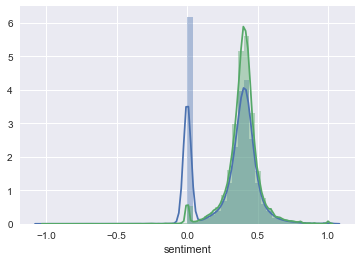

In [75]:
#Sentiment distribution

sns.distplot(df_listings_new_sent.sentiment.fillna(value=0));

sns.distplot(df_listings_new_sent.sentiment[df_listings_new_sent.sentiment.notnull()]);

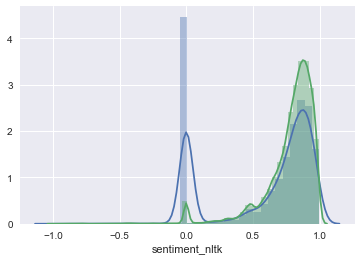

In [76]:
#Sentiment distribution nltk

sns.distplot(df_listings_new_sent.sentiment_nltk.fillna(value=0));

sns.distplot(df_listings_new_sent.sentiment_nltk[df_listings_new_sent.sentiment_nltk.notnull()]);

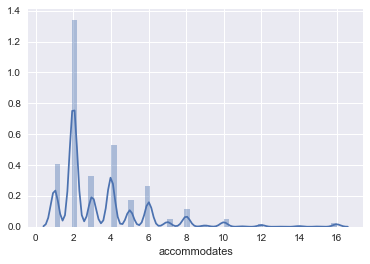

In [77]:
sns.distplot(df_listings_new_sent.accommodates);

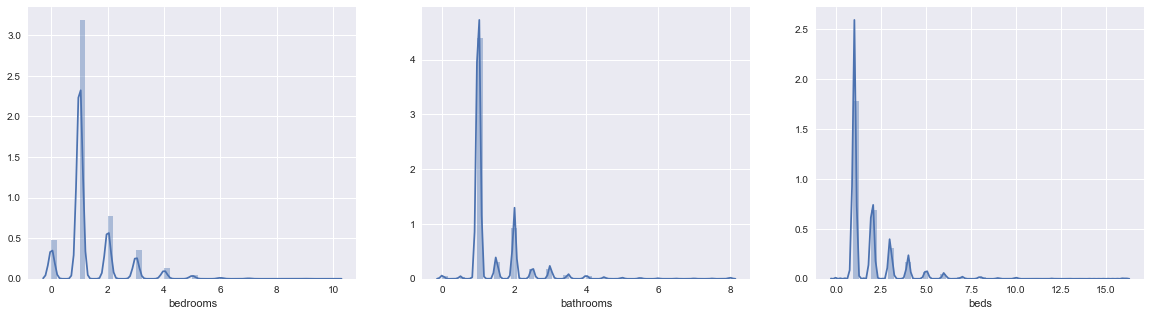

In [78]:
#bedrooms, bathrooms and beds

f, axes = plt.subplots(1, 3,figsize=(20,5))

sns.distplot(df_listings_new_sent.bedrooms.fillna(value=0),ax=axes[0]);

sns.distplot(df_listings_new_sent.bathrooms.fillna(value=0),ax=axes[1]);

sns.distplot(df_listings_new_sent.beds.fillna(value=0),ax=axes[2]);

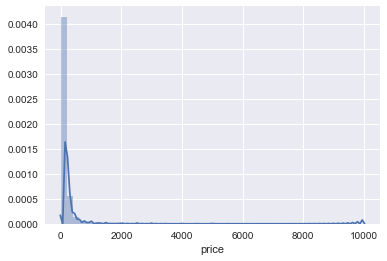

In [79]:
#Price

sns.distplot(df_listings_new_sent.price.fillna(value=0));

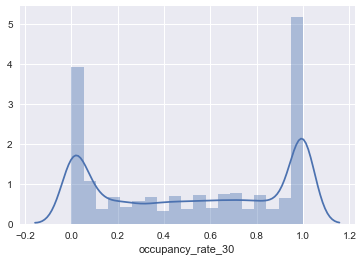

In [80]:
#Occupancy rate

sns.distplot(df_listings_new_sent.occupancy_rate_30.fillna(value=0));

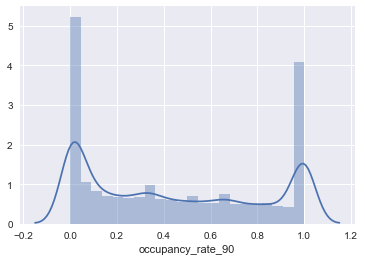

In [81]:
#Occupancy rate

sns.distplot(df_listings_new_sent.occupancy_rate_90.fillna(value=0));

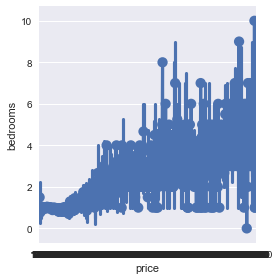

In [82]:
#Check price and number of bedrooms

sns.factorplot(x='price',y='bedrooms',data=df_listings_new_sent,kind='point')

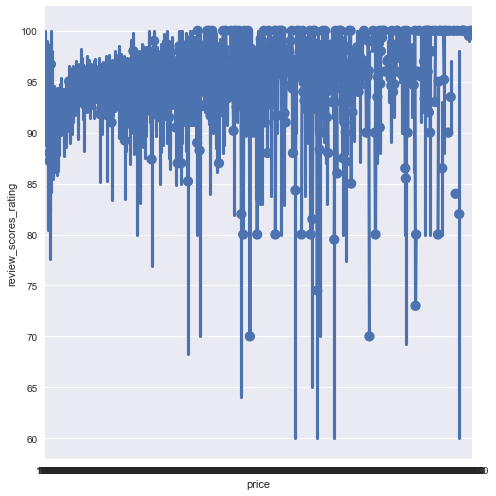

In [83]:
#Check price and reviews score

sns.factorplot(
    x='price',y='review_scores_rating',data=df_listings_new_sent,kind='point',size=7)

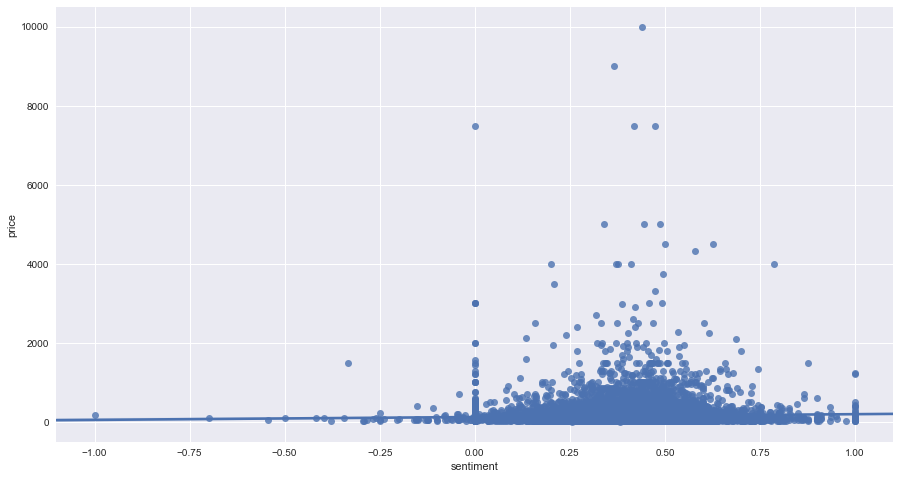

In [84]:
#Check sentiment and price

p=sns.regplot(x='sentiment',y='price',data=df_listings_new_sent)
p.figure.set_size_inches(15, 8)
sns.despine()

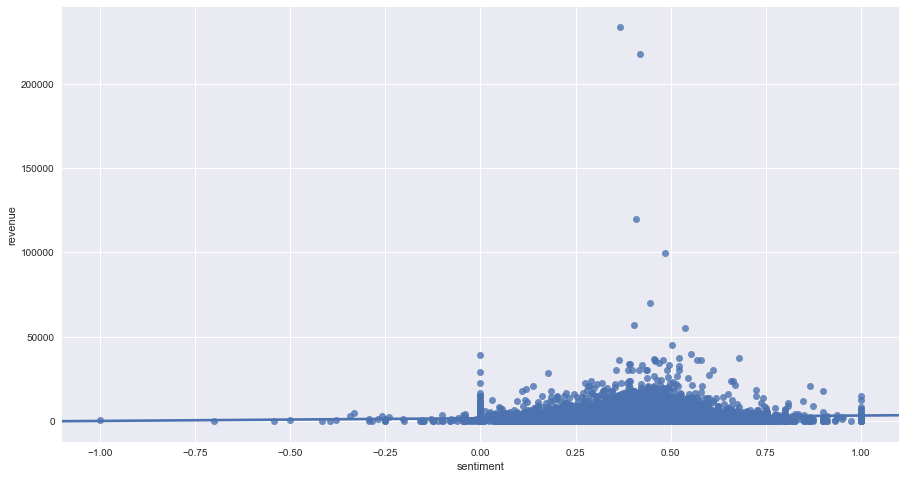

In [85]:
#Check sentiment and revenue

p=sns.regplot(x='sentiment',y='revenue',data=df_listings_new_sent_am)
p.figure.set_size_inches(15, 8)
sns.despine()

# 3. Classification

In order to understand what are the most important features to determine if a listing is successful or not, we will train a classifier to get which features are more important to build the tree.

## 3.1 Preparing data for classification

We will use the following features to predict if the listing is successful or not:

 - host_is_superhost
 - property_type
 - room_type
 - bedrooms
 - bed_type
 - number_of_reviews
 - review_scores_rating
 - cancellation_policy
 - sentiment_nltk
 - request_deposit
 - clean_perc
 
As well as dummies for all the amenities: 24-hour check-in, Air conditioning and 88 more.

In [86]:
##Read the data processed before
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("listings_new_sent_am.csv")

In [87]:
##We will keep the following variables:

keep=['revenue','host_is_superhost','property_type','room_type','bedrooms',\
      'bed_type','number_of_reviews','review_scores_rating','cancellation_policy',\
      'sentiment_nltk','host_has_profile_pic','host_identity_verified',\
      'bathrooms','beds','require_guest_profile_picture','require_guest_phone_verification',\
      'request_deposit','clean_perc']

##Check nas
nulls={}
for feat in keep:
    nulls[feat]=df[feat].isnull().sum()*1.0/len(df[feat])
    
nulls

{'bathrooms': 0.003103702044603718,
 'bed_type': 0.0,
 'bedrooms': 0.0011198924903209292,
 'beds': 0.0018878187693981377,
 'cancellation_policy': 0.0,
 'clean_perc': 0.0,
 'host_has_profile_pic': 0.0,
 'host_identity_verified': 0.0,
 'host_is_superhost': 0.0,
 'number_of_reviews': 0.0,
 'property_type': 0.0,
 'request_deposit': 0.0,
 'require_guest_phone_verification': 0.0,
 'require_guest_profile_picture': 0.0,
 'revenue': 0.0,
 'review_scores_rating': 0.24084087927558953,
 'room_type': 0.0,
 'sentiment_nltk': 0.2311138130739449}

In [88]:
##First check bedrooms: 35 records with no value in bedroom. We will
#remove this records from the dataset
df[df.bedrooms.isnull()][['id','room_type','bed_type','bedrooms','beds']]
len(df[df.bedrooms.isnull()])

##Keep just records with not null values in bedrooms.
df2 = df[df.bedrooms.notnull()]

##Check
len(df)-len(df2)

,id,room_type,bed_type,bedrooms,beds
900,1237815,Entire home/apt,Real Bed,NaN,1.0
909,1698049,Entire home/apt,Real Bed,NaN,1.0
1383,17860823,Private room,Real Bed,NaN,NaN
2925,17624607,Private room,Real Bed,NaN,NaN
3637,106052,Entire home/apt,Real Bed,NaN,1.0
5185,16811843,Private room,Real Bed,NaN,NaN
5874,2095010,Entire home/apt,Real Bed,NaN,NaN
7536,16929053,Private room,Real Bed,NaN,NaN
7661,1758811,Entire home/apt,Real Bed,NaN,2.0
8854,101702,Entire home/apt,Real Bed,NaN,1.0


35

35

In [89]:
#Change 0 bedrooms to 1
df2.bedrooms = df2.bedrooms.apply(lambda x: 1 if x==0 else x)

In [90]:
##Now lets work on review_score_rating and sentiment.
##We will fill nulls.

df2.review_scores_rating = df2.review_scores_rating.fillna(value=0)
df2.sentiment_nltk = df2.sentiment_nltk.fillna(value=0)
df2.bathrooms = df2.bathrooms.fillna(value=df2.bathrooms.mean())
df2.beds = df2.beds.fillna(value=df2.beds.mean())

In [91]:
nulls={}
for feat in keep:
    nulls[feat]=df2[feat].isnull().sum()*1.0/len(df2[feat])
    
nulls

{'bathrooms': 0.0,
 'bed_type': 0.0,
 'bedrooms': 0.0,
 'beds': 0.0,
 'cancellation_policy': 0.0,
 'clean_perc': 0.0,
 'host_has_profile_pic': 0.0,
 'host_identity_verified': 0.0,
 'host_is_superhost': 0.0,
 'number_of_reviews': 0.0,
 'property_type': 0.0,
 'request_deposit': 0.0,
 'require_guest_phone_verification': 0.0,
 'require_guest_profile_picture': 0.0,
 'revenue': 0.0,
 'review_scores_rating': 0.0,
 'room_type': 0.0,
 'sentiment_nltk': 0.0}

## 3.2 Preparing X and y

In [92]:
y=df2.is_successful_c

In [93]:
len(am_list)
am_list2=np.delete(am_list,[91])
am_list2=np.delete(am_list2,[90])

keep_final = keep + am_list2.tolist()

keep_final

X = df2[keep_final]

92

['revenue',
 'host_is_superhost',
 'property_type',
 'room_type',
 'bedrooms',
 'bed_type',
 'number_of_reviews',
 'review_scores_rating',
 'cancellation_policy',
 'sentiment_nltk',
 'host_has_profile_pic',
 'host_identity_verified',
 'bathrooms',
 'beds',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'request_deposit',
 'clean_perc',
 '24-hour check-in',
 'Air conditioning',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bed linens',
 'Breakfast',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children\xe2\x80\x99s books and toys',
 'Children\xe2\x80\x99s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Doorman Entry',
 'Dryer',
 'EV charger',
 'Elevator in building',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Family/kid friendly',

In [94]:
X = pd.get_dummies(X)

In [95]:
X.columns.tolist()

['revenue',
 'host_is_superhost',
 'bedrooms',
 'number_of_reviews',
 'review_scores_rating',
 'sentiment_nltk',
 'host_has_profile_pic',
 'host_identity_verified',
 'bathrooms',
 'beds',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'request_deposit',
 'clean_perc',
 '24-hour check-in',
 'Air conditioning',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bed linens',
 'Breakfast',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children\xe2\x80\x99s books and toys',
 'Children\xe2\x80\x99s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Doorman Entry',
 'Dryer',
 'EV charger',
 'Elevator in building',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'First aid kit',
 'Free 

In [96]:
X = X.drop(['revenue'],axis=1)

In [97]:
X.head()

,host_is_superhost,bedrooms,number_of_reviews,review_scores_rating,sentiment_nltk,host_has_profile_pic,host_identity_verified,bathrooms,beds,require_guest_profile_picture,...,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,0.0,5.0,0,0.0,0.000000,1.0,0.0,7.0,5.0,0.0,...,0,0,0,0,1,0,0,1,0,0
1,1.0,1.0,33,93.0,0.814103,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,1,1,0,0,0,0
2,1.0,1.0,14,100.0,0.893307,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,1,1,0,0,0,0
3,1.0,1.0,22,100.0,0.885386,1.0,0.0,1.0,3.0,0.0,...,0,0,0,0,1,1,0,0,0,0
4,0.0,1.0,3,93.0,0.905900,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,1,1,0,0,0,0


In [98]:
##Check dimensions

y.shape
X.shape

(31218L,)

(31218, 126)

## 3.3 Fit Classifier

We will fit Decission Tree and Random Forest to then pick the best model in order the understand the main features used by the tree to determine if a listing is succesful or not

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [100]:
## Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [101]:
## List of classifiers
clfs = [DecisionTreeClassifier(random_state=0), RandomForestClassifier(n_jobs=-1)]

In [102]:
## Parameters for crossvalidation
nfolds = 10
kf = KFold(n_splits=nfolds,random_state=0,shuffle=True)

In [103]:
## Fit classifiers to get the best one

maxAUC = -1
bestCL = ""
for cl in clfs:
    auc = cross_val_score(cl,X,y,cv=kf,n_jobs=-1,scoring='roc_auc').mean()
    print (str(cl) + ' ' + str(auc))
    if auc > maxAUC:
        bestCL = cl
        maxAUC = auc
print('***********************************************')
print ('Best is... ' + str(bestCL) + ' ' + str(maxAUC))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best') 0.5452634584748824
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) 0.608416320878973
***********************************************
Best is... RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
       

Random Forest performs better so we we will try to tune this model to improve performance and then get the list of the most important features to build the tree.

## 3.4 Random Forest classifier

Now we will work with the Random Forest calssifier to find the best parameters possible and then to find the most important features after we train the classifier

<b><i>CAUTION: GRID SEARCH EXECUTION TAKES A LONG TIME</i></b>

In [106]:
##Grid search to find the best parameters
from sklearn.model_selection import GridSearchCV

parameters = {"max_depth": [2,4,6,8,10,12,None]
            ,"criterion": ('gini','entropy')
            ,"min_samples_split" :[2,3,4,5,6]
             ,"min_samples_leaf": [1,2,3,4,5]}
            

rf_regr = RandomForestClassifier()
model = GridSearchCV(rf_regr,parameters, n_jobs = -1, cv = 10)
model_fit = model.fit(X_train,y_train)

learned_parameters = model_fit.best_params_

In [107]:
learned_parameters

y_pred2 = model_fit.predict(X_test)

print "Train Accuracy :: ", accuracy_score(y_train, model_fit.predict(X_train))
print "Test Accuracy  :: ", accuracy_score(y_test, y_pred2)

confusion_matrix(y_test, y_pred2)
#f1_score(y_test, y_pred2, average='macro')

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 6}

Train Accuracy ::  0.7992712420917755
Test Accuracy  ::  0.6105060858424087


array([[2938,  753],
       [1679,  874]])

Train the model with the best parameters as a reference:

In [108]:
rf = RandomForestClassifier(criterion= 'gini',
                             max_depth= 12,
                             min_samples_leaf= 3,
                             min_samples_split= 2,
                             random_state = 0)

In [109]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [110]:
y_pred = rf.predict(X_test)

In [111]:
print "Train Accuracy :: ", accuracy_score(y_train, rf.predict(X_train))
print "Test Accuracy  :: ", accuracy_score(y_test, y_pred)

confusion_matrix(y_test, y_pred)

Train Accuracy ::  0.6926803876031072
Test Accuracy  ::  0.612427930813581


array([[3174,  517],
       [1903,  650]])

In [112]:
nfolds=10
kf=KFold(n_splits=nfolds,random_state=0,shuffle=True)

In [113]:
cross_val_score(rf,X,y, cv=kf,n_jobs=-1,scoring='roc_auc').mean()

0.6382052752090743

Now we will check the most important features:

In [114]:
##Check the importance of the features

feat = zip(X_train.columns,rf.feature_importances_)

important_features = pd.DataFrame(list(feat), columns =['feature','importance'])

important_features.sort_values(by=['importance'],ascending= False)

,feature,importance
12,clean_perc,0.103968
4,sentiment_nltk,0.090037
2,number_of_reviews,0.074125
3,review_scores_rating,0.059474
8,beds,0.033664
38,Dryer,0.026262
7,bathrooms,0.020725
115,room_type_Shared room,0.020497
63,Kitchen,0.019698
14,Air conditioning,0.018128


# 4. Findings

## 4.1 Amenities

<b/>Summary</b>: Having Kitchen, Washer and Dryer increases the chances of success.

In this section we will answer-

<b>"What are the most important amenities required for a listing to become a succesful listing?"</b>

We will explore the 20 most important amenities according to the Random Forest classifier that we trained.

### 4.1.1 Validate finding

#### Most important amenities

In [115]:
##Check the most important amenities
important_amenities=important_features[important_features.isin(am_list2.tolist()\
                                )['feature']].sort_values(by=['importance'],ascending=False)

##Get those with importance higher than zero
important_amenities = important_amenities[important_amenities.importance>0]
important_amenities

,feature,importance
38,Dryer,0.026262
63,Kitchen,0.019698
14,Air conditioning,0.018128
23,Cable TV,0.015827
95,TV,0.014745
97,Washer,0.013759
94,Suitable for events,0.012532
60,Internet,0.012527
40,Elevator in building,0.012075
90,Smoke detector,0.011341


#### Amenities importance and success rate

In [116]:
##Initialize the data frame
success_amenities = pd.DataFrame(columns=['amenitie','False','True'])

In [117]:
##Get the 20 most important amenities
n = 20
list_20 =important_amenities.feature[0:n].tolist()

##Calculate the diference in revenue for each amenitie
var = 'is_successful_c'

for am in list_20:
    
    sub_df = df2.groupby(am,as_index=False)[var].mean().T
    append_df = pd.DataFrame([[am, sub_df.values[1][0], sub_df.values[1][1]]], 
                             columns=['amenitie','False','True'])
    
    success_amenities = success_amenities.append(append_df)

success_amenities['% var.']=((success_amenities.True-success_amenities.False\
                             )*1.0/success_amenities.False)*100

Populating the interactive namespace from numpy and matplotlib


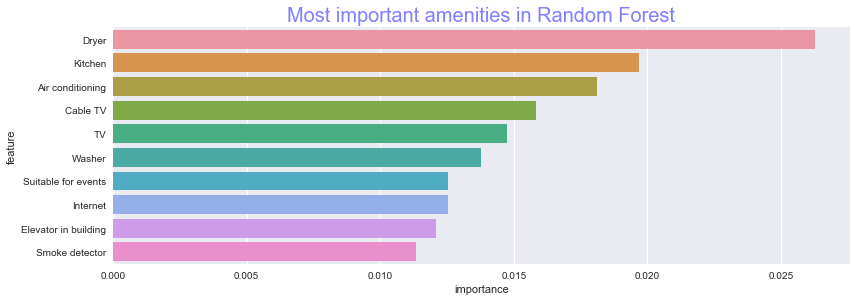

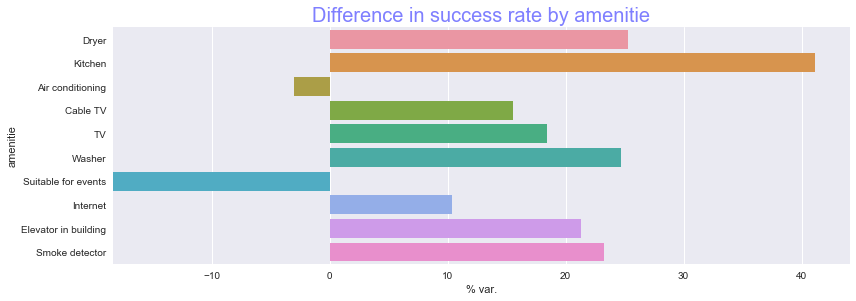

In [118]:
# Plot important amenities and successful rate
import seaborn as sns
%pylab inline

p1=sns.factorplot(x='importance', y='feature', data=important_amenities[0:10]\
                  ,kind='bar',aspect=3);
p1.ax.set_title('Most important amenities in Random Forest',fontsize=20,color="b",alpha=0.5);

p2=sns.factorplot(x='% var.', y='amenitie', data=success_amenities.head(10)
               , kind='bar',aspect=3);
p2.ax.set_title('Difference in success rate by amenitie',fontsize=20,color="b",alpha=0.5);

Based on the first plot we can say that Dryer, Kitchen, Cable TV, Elevator, Air conditiing and Washer are the most important amenities to define the success of a listing.

If we look at the second plot, we can see that those listings that include Dryer, Kitchen and Washer are the ones with the highest difference in success rate. We can observe that the proportion of succeful listings having Kitchen is more than 40% higher than the proportion of succesful listings that do not have Kitchen. Similarly, the differnce for listings that include Dryer is around 25% and for the listings that include Washer is around 25%.

Suprinsigly, the proportion of succesful listings including Air conditioning is 3% less than those listings including Air conditioning.

Now, let's see what happens with those listings that have Kitchen + Washer + Dryer, or Washer + Dryer or just Washer compared to those that do not include the corresponding combination.

In [119]:
combo_df= pd.DataFrame(columns=['Combo','False','True'])

c1_t=df[((df.Dryer==1) & (df.Kitchen==1) & (df.Washer==1))]['is_successful_c'].mean()
c1_f=df[((df.Dryer==0) & (df.Kitchen==0) & (df.Washer==0))]['is_successful_c'].mean()

combo_df = combo_df.append(pd.DataFrame(
    [['Kitchen + Washer + Dryer',c1_f,c1_t]],columns=['Combo','False','True']))

c2_t=df[(df.Dryer==1) & (df.Washer==1)]['is_successful_c'].mean()
c2_f=df[(df.Dryer==0) & (df.Washer==0)]['is_successful_c'].mean()

combo_df = combo_df.append(pd.DataFrame(
    [['Washer + Dryer',c2_f,c2_t]],columns=['Combo','False','True']))

c3_t=df[df.Washer==1]['is_successful_c'].mean()
c3_f=df[df.Washer==0]['is_successful_c'].mean()

combo_df = combo_df.append(pd.DataFrame(
    [['Washer',c3_f,c3_t]],columns=['Combo','False','True']))

combo_df['% var.'] = ((combo_df.True-combo_df.False)/combo_df.False)*100

combo_df                                                         

,Combo,False,True,% var.
0,Kitchen + Washer + Dryer,0.280672,0.442154,57.533881
0,Washer + Dryer,0.347309,0.437827,26.062698
0,Washer,0.349365,0.436389,24.909258


We can see that the proportion of success rate increases by 57.53% for those listings that include Kitchen + Washer + Dryer when compared to those that do not have any of those amenities.

It is interesting to note that the proportion of success rate increases by 26.06% for those listings that include Washer + Dryer compared to those that do not include those amenities. These amenities are easy to install and inexpensive and could be a way to imporve the chances of being succesful. 

### 4.1.2 Managerial Insight

Based on our results we can recommend the following:

- For those who are interested in entering the Airbnb rental business should have Kitchen, Washer and Dryer or Washer and Dryer as they are important factors for the success of the business.

- For those who are already in the business and don't have those amenities should install them. 

### 4.1.3 Machine Learning

We leverage on machine learning tools to be able to identify the most important amenities. Our approach was:

- Train a Decission Tree and a Random Forest to pick the best model. In this case Random Forest performed better.
- Perfrom a Grid Search in order to find the best parameters for our Random Forest classifier
- Train the Random Forest classifier with best parameters
- Get the list of the most important features used by the Random Forest
- Select features associated with amenities with importance higher than 0

## 4.2 Sentiment

<b/>Summary:</b> Not having reviews is not a problem at all

In this section we will explore how sentiments associated to reviews are related to success.

### 4.2.1 Validate finding

When we trained the Random Forest Classifier we could see that sentiment_nltk was an important feature in the tree, that gives us a clue that we could find some finding relating sentiment and success.

In [120]:
##Check sentiment
df3 = df2

## Create bins for sentiment in order to plot
df3['sentiment_bin'] = pd.cut(df3['sentiment_nltk'], [-1, -0.001,.25, 0.5, 0.75, 1])

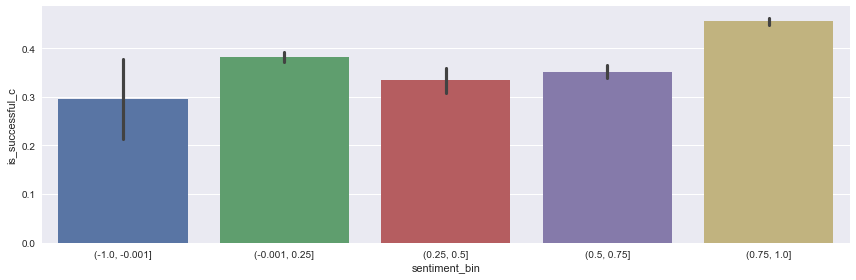

In [121]:
sns.factorplot(x='sentiment_bin',y='is_successful_c',data=df3,kind='bar',aspect=3)

Based on this we can conclude:

- Listings with negative average sentiment reviews are definitely less likely to be successful
- Listings with strong average positive sentiment are definitely more likely to be successful
- What is happening with the (-0.001 0.25] bin ?
    - 97% of the listings in this category do not have any reviews
    - Based on this data it's surprising that listings without reviews are more likely to be sucessful than those with moderate positive sentiment 

### 4.2.2 Managerial Insight

Unless Airbnb hosts are pretty sure that they will get strongly positive reviews, not having reviews is not a problem at all. This is helpful to all those hosts who might think that not having reviews could hurt their chances of success. Therefore, reviews should be encouraged by hosts only if they are confident that guests will write very good reviews.

### 4.1.3 Machine Learning

The sentiment score used as a feature in our analysis was obtained using a machine learning library- natural language processing called nltk. Using this library we were able to process each review and get average sentiment score for each listing. 

Then, using the same approach explained in the previous finding, we noticed that sentiment was an important feature for our classifier and therefore we should explore the relationship between sentiment and success rate. 

## 4.3 Location

<b/>Summary</b>: If you are interested in entering into the Airbnb business or if you want to expand your Airbnb business, look for Sunset Park and Playa del Rey area.

In this section we will explore what locations might be good to run an Airbnb listing.

### 4.3.1 Validate finding

#### Clustering to find the most competitive places

In [122]:
from sklearn.cluster import KMeans

In [123]:
# Select listings with not null values in review score ratings
df_c = df2[df2.review_scores_rating.notnull()]

In [124]:
# Create the new variable number of amenities to use it for clustering
df_c['number_amenities']=df_c.loc[:,'24-hour check-in':'Wireless Internet'].sum(axis=1)

df_c.number_amenities.head()

0    25
1     0
2    13
3    22
4     9
Name: number_amenities, dtype: int64

In [125]:
# Define the variables that will be kept for clustering

keep_c=['bedrooms','price','occupancy_rate_30','review_scores_rating','number_amenities']

In [126]:
# Define the new data frame for clustering

new_df=df_c[keep_c]

In [127]:
# Initialize the clustering model

clus = KMeans(n_clusters=20,n_jobs=-1,random_state=0)

In [128]:
# Fit the data

clus.fit(new_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [129]:
# Create the column 'labels' to store the results of clustering

new_df['labels']=clus.labels_

In [130]:
# Check clusters to find those clusters with highest occupancy rate and highest rating scores

new_df.groupby('labels').mean()

,bedrooms,price,occupancy_rate_30,review_scores_rating,number_amenities
labels,,,,,
0,2.705682,374.757955,0.449811,82.517045,20.718182
1,4.137931,4919.034483,0.275862,17.241379,16.862069
2,1.153743,106.413586,0.595574,94.647404,18.170559
3,5.250000,9958.291667,0.176389,8.333333,13.833333
4,4.388235,1900.247059,0.193333,33.117647,20.105882
5,3.438462,965.657692,0.318846,51.346154,19.992308
6,4.655172,3854.137931,0.197701,23.931034,19.275862
7,4.444444,7263.333333,0.185185,22.111111,21.000000
8,1.044687,57.089374,0.474619,0.533779,13.425757


In [131]:
# Include more variables to plot

keep3=['is_successful_c','latitude','longitude','property_type','room_type',
       'bedrooms','bathrooms','beds','bed_type','cancellation_policy','host_has_profile_pic',
       'host_identity_verified','require_guest_profile_picture','request_deposit']

In [132]:
# Define the new data frame with more variables

X3 = df_c[keep3]

In [133]:
# Include labels from clustering

X3['cluster']=clus.labels_

#### Exploring LA

In [134]:
import plotly.plotly as py
from plotly.graph_objs import *

We will plot a quick overview of the listings, each color is a different cluster

In [135]:
# Overview of listings

mapbox_access_token = 'pk.eyJ1IjoicHJvZGlsbG8iLCJhIjoiY2plc3cxbWJnMGVsbzJ3bXBidHJkOGRhYSJ9.LxiLCXUBQwVDiCePYR2MvQ'

data = Data([
    Scattermapbox(
        lat=X3.latitude,
        lon=X3.longitude,
        mode='markers',
        marker=Marker(
            size=2.5,
            color =X3['cluster'],
            colorscale= 'Jet'
        ),
        text=X3.cluster,
    )
])
layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=34.052235,
            lon=-118.243683
        ),
        pitch=0,
        zoom=8.5
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

Based on the clustering results, we identified the clusters 2, 10, 11 and 13 as clusters with a high average occupancy rate (above 50%) and high rating score (above 90). Also we identified clusters 8 and 18 as clusters that in average have good occupancy rates, are low priced, but most of them don't have rating scores. In order to visualize these clusters, we will define the variable <b><i>'most_competitive'</i></b> to identify listings that belong to those clusters.

- Listings belonging to to clusters 2, 10, 11 and 13 will take the value of 1
- Listings belonging to to clusters 8 and 18 will take the value of 0.5
- All other listings will take the value of zero

Zones with a high concentration of listings belonging to the clusters mentioned before will be considered as highly competitive areas and the objective of the plots that will come later is to visualize those areas in order to find good potential places to locate an Airbnb listing.

In [136]:
X3['most_competitive']=(
    (X3.cluster==2) | (X3.cluster==10) | (X3.cluster==11) | (X3.cluster==13))*1.0
X3['most_competitive']=X3['most_competitive']+((X3.cluster==8) | (X3.cluster==18))*0.5
#X3.most_competitive=X3.cluster.apply(lambda x: 0.5 if x==13 else x)
X3.head()

,is_successful_c,latitude,longitude,property_type,room_type,bedrooms,bathrooms,beds,bed_type,cancellation_policy,host_has_profile_pic,host_identity_verified,require_guest_profile_picture,request_deposit,cluster,most_competitive
0,0.0,34.530350,-118.227088,House,Entire home/apt,5.0,7.0,5.0,Real Bed,strict,1.0,0.0,0.0,True,17,0.0
1,0.0,34.485431,-118.125380,Other,Private room,1.0,1.0,1.0,Real Bed,flexible,1.0,0.0,0.0,False,11,1.0
2,0.0,34.510130,-118.212407,House,Private room,1.0,1.0,1.0,Real Bed,flexible,1.0,1.0,0.0,False,11,1.0
3,1.0,34.515486,-118.230742,Other,Entire home/apt,1.0,1.0,3.0,Real Bed,flexible,1.0,0.0,0.0,False,13,1.0
4,0.0,34.031419,-118.299016,Apartment,Private room,1.0,1.0,1.0,Real Bed,flexible,1.0,1.0,0.0,False,11,1.0


The next plot gives an overview of the listings in our dataset, Red and Green dots identify competitive areas. Looking at the map we can see how competitive is the Airbnb business in LA.

In [137]:
mapbox_access_token = 'pk.eyJ1IjoicHJvZGlsbG8iLCJhIjoiY2plc3cxbWJnMGVsbzJ3bXBidHJkOGRhYSJ9.LxiLCXUBQwVDiCePYR2MvQ'

data = Data([
    Scattermapbox(
        lat=X3.latitude,
        lon=X3.longitude,
        mode='markers',
        marker=Marker(
            size=2.5,
            color =X3['most_competitive'],
            colorscale= 'Jet'#'YlOrRd'
        ),
        text=[],
    )
])
layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=34.052235,
            lon=-118.243683
        ),
        pitch=0,
        zoom=8.5
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

Exploring the map, we noticed that surprinsigly there is an area in Santa Monica called Sunset Park, close to the airport, and close to Ocean Park, that is less dense in terms of the competitive listings available and therefore could be a good area to run an Airbnb listing.

In [138]:
mapbox_access_token = 'pk.eyJ1IjoicHJvZGlsbG8iLCJhIjoiY2plc3cxbWJnMGVsbzJ3bXBidHJkOGRhYSJ9.LxiLCXUBQwVDiCePYR2MvQ'

data = Data([
    Scattermapbox(
        lat=X3.latitude,
        lon=X3.longitude,
        mode='markers',
        marker=Marker(
            size=4,
            color =X3['most_competitive'],
            colorscale= 'Jet'#'YlOrRd'
        ),
        text=[],
    )
])
layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=34.00,
            lon=-118.45
        ),
        pitch=0,
        zoom=12
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

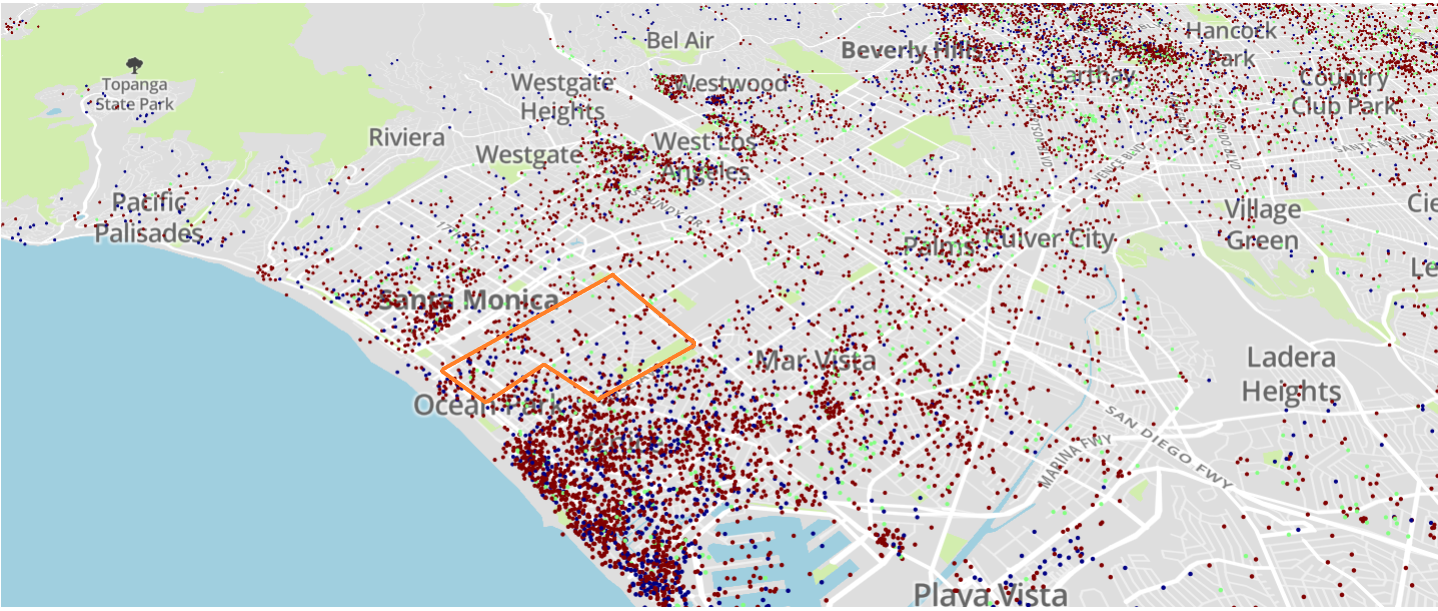

In [140]:
from IPython.display import Image
Image("Location1zoom.png")

Exploring further, we also noticed that Playa Vista area, next to Santa Monica, is also close to one the most demanded areas in LA and is less dense in terms of competitive listings available. This also could be a good place to run an Airbnb listing.

In [139]:
mapbox_access_token = 'pk.eyJ1IjoicHJvZGlsbG8iLCJhIjoiY2plc3cxbWJnMGVsbzJ3bXBidHJkOGRhYSJ9.LxiLCXUBQwVDiCePYR2MvQ'

data = Data([
    Scattermapbox(
        lat=X3.latitude,
        lon=X3.longitude,
        mode='markers',
        marker=Marker(
            size=4,
            color =X3['most_competitive'],
            colorscale= 'Jet'#'YlOrRd'
        ),
        text=[],
    )
])
layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=33.95,
            lon=-118.44
        ),
        pitch=0,
        zoom=11
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

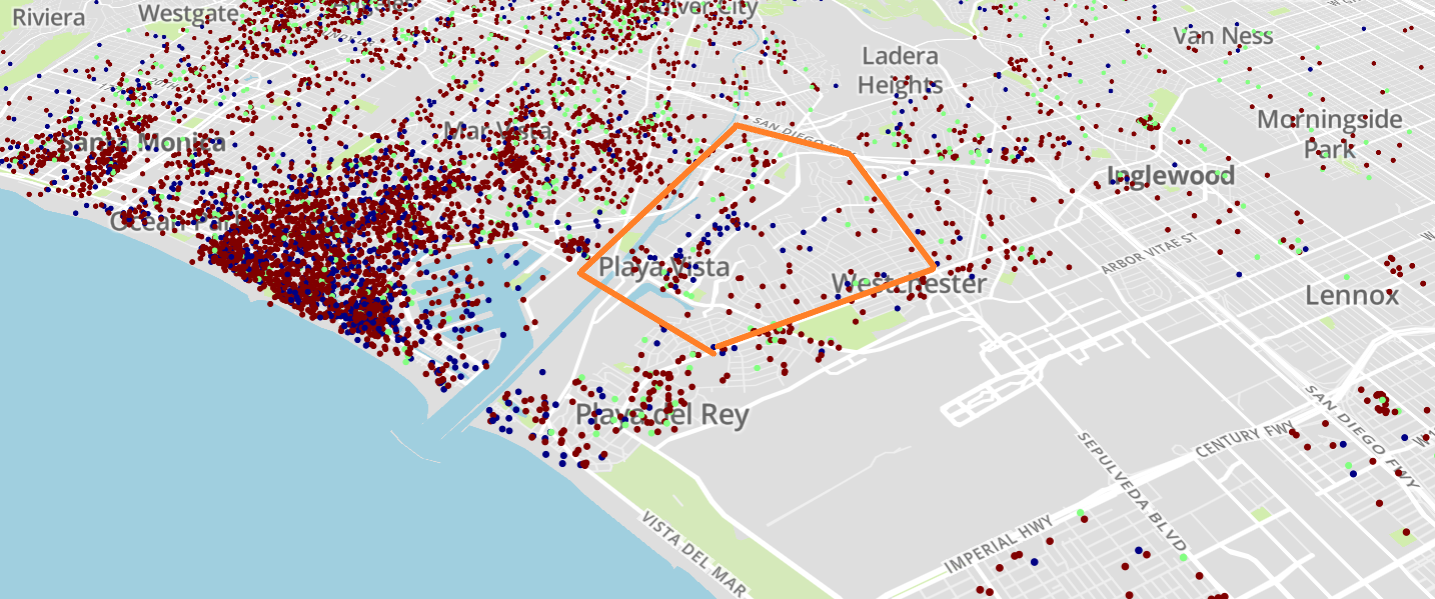

In [141]:
Image("Location2zoom.png")

### 4.3.2 Managerial Insight

Using this interactive map, we were able to recommend two places to explore for the hosts interested in expanding their Airbnb business or are thinking about entering to the business. 

Sunset Park and Playa Vista are next to highly demanded areas but are less overcrowded than those areas .Hence, these could be interesting places to locate an Airbnb listing. 

This tool that we designed can be shared with those who might be interested in making further explorations of the LA Airbnb business and can be complemented with more data in the future.

### 4.1.3 Machine Learning

For this finding, we used the unsupervised machine learning algorithm KMeans in order to identify clusters of highly competitive listings. We used the variables 'bedrooms', 'price', 'occupancy_rate_30', 'review_scores_rating' and 'number_amenities' to find 20 clusters. 

After finding the clusters, we averaged the variables for each cluster and we looked for those clusters that in average had the highest occupancy rate and rating score to define the listings in those clusters as the most competitive ones.